# # Import Dependencies

In [17]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
matplotlib.use('TkAgg')
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


## Setup NLP Pipeline and Data Cleaning 

In [18]:
##define nlp and start cleaning data
nlp= spacy.load("en")

# List of stop words to equalize data
stop_list = ["Anxiety","anxiety"]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [19]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

## Import data, create a list of lists and push through NLP pipeline

In [20]:
doc_dep = pd.read_csv(r'2020_March_r_Anxiety.csv')
doc_dep = doc_dep[doc_dep.Body != '[removed]']


In [21]:
#create a list of documents (list of lists) 
text_doc = doc_dep['Body'].tolist()

In [22]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [23]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)
    
df_doc_dep = pd.DataFrame(empt,columns = ['Body'])
#df_doc_dep is a dataframe that has cleaned posts from Depression subreddit.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)


df_doc_dep['label'] = 0

In [24]:
df_doc_dep

,Body,label
0,thing anxious focus mean study like maybe lazy...,0
1,know midnight know homework know school know X...,0
2,med euphoric feeling consider narcotic,0
3,heart feel sense yesterday continually worried...,0
4,fear swallow small bone eat chicken sure bite ...,0
...,...,...
7149,want sell ps4 use anymore want money hard pers...,0
7150,yesterday(this morning sleep midnight 12 wake ...,0
7151,bath new house cause flood basement live boyfr...,0
7152,mean find self cross leg,0


## Vectorize words with TFIDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.2,
    min_df=8,
    max_features=None,
    ngram_range=(1, 1),
    norm=None,
    binary=True,
    use_idf=True,
    sublinear_tf=False
)

vectorizer = vectorizer.fit(df_doc_dep.Body)
tfidf = vectorizer.transform(df_doc_dep.Body)
vocab = vectorizer.get_feature_names()
print(len(vocab))

3498


## Get top 50 tokens 

/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/base.py:259: DeprecationWarning: this method is deprecated, please use show() instead
  "this method is deprecated, please use show() instead", DeprecationWarning


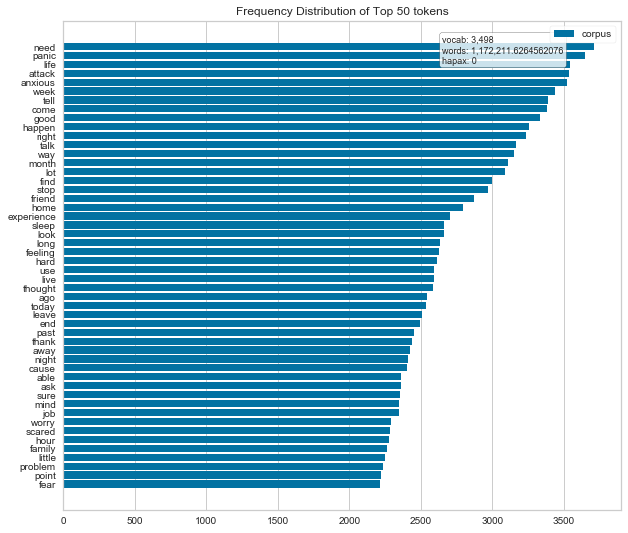

In [68]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,9))
docs = vectorizer.fit_transform(df_doc_dep.Body)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## Semi-Supervised Total Correlation Explanation w/CorexTopic

In [13]:
#import corextopic

from corextopic import corextopic as ct
anchors = []
model = ct.Corex(n_hidden=6, seed=41)
model = model.fit(
    tfidf,
    words=vocab
)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [27]:
alist=[];
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: job ,need ,come ,month ,find ,week ,long ,lot ,point ,leave ,new ,ago ,right ,able ,place
Topic #2: friend ,talk ,good ,life ,tell ,school ,end ,person ,family ,love ,relationship ,care ,social ,college ,parent
Topic #3: way ,use ,thought ,ask ,look ,problem ,fear ,maybe ,believe ,kind ,etc ,actually ,different ,reason ,realize
Topic #4: happen ,night ,little ,hour ,away ,mind ,wake ,sit ,bed ,sleep ,head ,bit ,fall ,later ,cry
Topic #5: live ,home ,virus ,health ,stay ,covid ,case ,19 ,mental ,news ,coronavirus ,risk ,pay ,state ,read
Topic #6: symptom ,doctor ,chest ,pain ,attack ,heart ,panic ,mg ,prescribe ,body ,breath ,experience ,medication ,effect ,blood


In [28]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    ["job"],
    ["relationship"],
    ["fear"],
    ["sleep"],
    ["coronavirus"],
    ["symptom"],

]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=6, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=1 # Tell the model how much it should rely on the anchors
)

In [29]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: job ,need ,come ,end ,school ,pay ,leave ,new ,able ,let ,class ,money ,college ,break ,place
Topic #2: friend ,talk ,good ,tell ,life ,relationship ,way ,person ,ask ,love ,look ,care ,point ,social ,understand
Topic #3: find ,lot ,long ,use ,thought ,fear ,post ,hard ,mind ,problem ,old ,issue ,hope ,read ,write
Topic #4: night ,hour ,happen ,sleep ,away ,ago ,wake ,little ,bed ,fall ,sit ,bit ,later ,feeling ,cry
Topic #5: live ,home ,family ,virus ,stay ,week ,parent ,covid ,case ,right ,house ,close ,19 ,die ,health
Topic #6: doctor ,symptom ,chest ,attack ,heart ,pain ,panic ,experience ,month ,mg ,body ,medication ,prescribe ,breath ,past


In [30]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range(6)]).astype(float)
topic_df.iloc[0:10]

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,1.0


## Topic distribution

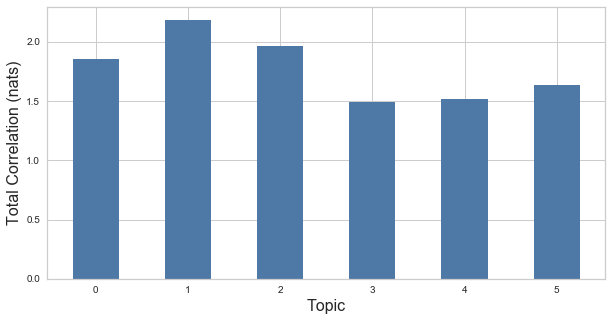

In [31]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [32]:
# Print a single topic from CorEx topic model
model.get_topics(topic=0, n_words=30)
model.get_topics(topic=1, n_words=30)
model.get_topics(topic=2, n_words=30)
model.get_topics(topic=3, n_words=30)
model.get_topics(topic=4, n_words=30)
model.get_topics(topic=5, n_words=30)


[('doctor', 0.0751688017546699),
 ('symptom', 0.06945073227005788),
 ('chest', 0.06236843486236199),
 ('attack', 0.05938422100155441),
 ('heart', 0.058039983871997686),
 ('pain', 0.0579394946644413),
 ('panic', 0.050499061035172516),
 ('experience', 0.04704706126910305),
 ('month', 0.04246222572254024),
 ('mg', 0.03914481612826531),
 ('body', 0.0387919457723616),
 ('medication', 0.03538519079223343),
 ('prescribe', 0.03532295920484099),
 ('breath', 0.033256934423599546),
 ('past', 0.032434313990686386),
 ('cause', 0.028710079560898775),
 ('psychiatrist', 0.027369720810066382),
 ('physical', 0.0265054250883851),
 ('breathing', 0.025810744925183347),
 ('blood', 0.025701461741491582),
 ('head', 0.02529093996097007),
 ('effect', 0.024494764229145833),
 ('headache', 0.02260921092143014),
 ('normal', 0.022037229969756548),
 ('diagnose', 0.020749767409925613),
 ('nan', -0.019708847838696645),
 ('brain', 0.019348370520980932),
 ('sensation', 0.01928950242010206),
 ('dose', 0.019112871549795456

In [33]:
#from corextopic import vis_topic as vt
#file = vt.vis_rep(model, column_label=words, prefix='topic-model-example')


NameError: name 'words' is not defined

# # termite plot

In [34]:
#create dataframe for termite plot
#termite_df = pd.DataFrame(columns=['Word', 'Weight', 'Topic'])
topic_0 = model.get_topics(topic=0, n_words=60)
topic_1 = model.get_topics(topic=1, n_words=60)
topic_2 = model.get_topics(topic=2, n_words=60)
topic_3 = model.get_topics(topic=3, n_words=60)
topic_4 = model.get_topics(topic=4, n_words=60)
topic_5 = model.get_topics(topic=5, n_words=60)
dict_topic_0 = {k:v for k,v in topic_0}
dict_topic_1 = {k:v for k,v in topic_1}
dict_topic_2 = {k:v for k,v in topic_2}
dict_topic_3 = {k:v for k,v in topic_3}
dict_topic_4 = {k:v for k,v in topic_4}
dict_topic_5 = {k:v for k,v in topic_5}
dict_df_0 = pd.DataFrame([dict_topic_0])
dict_df_1 = pd.DataFrame([dict_topic_1])
dict_df_2 = pd.DataFrame([dict_topic_2])
dict_df_3 = pd.DataFrame([dict_topic_3])
dict_df_4 = pd.DataFrame([dict_topic_4])
dict_df_5 = pd.DataFrame([dict_topic_5])
transposed_df_0 = dict_df_0.transpose().reset_index()
transposed_df_1 = dict_df_1.transpose().reset_index()
transposed_df_2 = dict_df_2.transpose().reset_index()
transposed_df_3 = dict_df_3.transpose().reset_index()
transposed_df_4 = dict_df_4.transpose().reset_index()
transposed_df_5 = dict_df_5.transpose().reset_index()
transposed_df_0 = transposed_df_0.rename(columns={transposed_df_0.columns[0]:'words', transposed_df_0.columns[1]: "tfidf"})
transposed_df_1 = transposed_df_1.rename(columns={transposed_df_1.columns[0]:'words', transposed_df_1.columns[1]: "tfidf"})
transposed_df_2 = transposed_df_2.rename(columns={transposed_df_2.columns[0]:'words', transposed_df_2.columns[1]: "tfidf"})
transposed_df_3 = transposed_df_3.rename(columns={transposed_df_3.columns[0]:'words', transposed_df_3.columns[1]: "tfidf"})
transposed_df_4 = transposed_df_4.rename(columns={transposed_df_4.columns[0]:'words', transposed_df_4.columns[1]: "tfidf"})
transposed_df_5 = transposed_df_5.rename(columns={transposed_df_5.columns[0]:'words', transposed_df_5.columns[1]: "tfidf"})
transposed_df_0['topic'] = 0
transposed_df_1['topic'] = 1
transposed_df_2['topic'] = 2
transposed_df_3['topic'] = 3
transposed_df_4['topic'] = 4
transposed_df_5['topic'] = 5

In [35]:
concat_1 = pd.concat([transposed_df_0, transposed_df_1])
concat_2 = pd.concat([transposed_df_2, transposed_df_3])
concat_3 = pd.concat([transposed_df_4, transposed_df_5])
concat_pre_final_1 = pd.concat([concat_1, concat_2])
termite_df = pd.concat([concat_pre_final_1, concat_3])

In [43]:
termite_df.to_csv(r'word_topic_data_anx.csv')
len(termite_df)

360

In [44]:
termite_df

,words,tfidf,topic
0,job,0.105194,0
1,need,0.070332,0
2,come,0.055740,0
3,end,0.051788,0
4,school,0.050596,0
...,...,...,...
55,severe,0.013773,5
56,stomach,0.013685,5
57,xanax,0.013591,5
58,notice,0.013065,5


In [45]:
termite_df_new = termite_df['words']


In [57]:
termite_df = pd.read_csv(r'word_topic_data_anx.csv')
termite_df

,words,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5
0,19,NaN,NaN,NaN,NaN,0.033630,NaN
1,able,0.03491,NaN,NaN,NaN,NaN,NaN
2,advice,NaN,NaN,0.024724,NaN,NaN,NaN
3,ago,NaN,NaN,NaN,0.043861,NaN,NaN
4,ask,NaN,0.049829,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
159,world,NaN,NaN,NaN,NaN,0.024749,NaN
160,worried,NaN,NaN,NaN,NaN,0.020573,NaN
161,worry,NaN,NaN,0.026901,NaN,NaN,NaN
162,write,NaN,NaN,0.029176,NaN,NaN,NaN


In [58]:
termite_df = pd.read_csv(r'word_topic_data_anx.csv')
termite_df.index = termite_df.words
termite_df = termite_df.drop(columns = 'words')

termite_df = termite_df.fillna(0)
termite_df

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5
words,,,,,,
19,0.00000,0.000000,0.000000,0.000000,0.033630,0.0
able,0.03491,0.000000,0.000000,0.000000,0.000000,0.0
advice,0.00000,0.000000,0.024724,0.000000,0.000000,0.0
ago,0.00000,0.000000,0.000000,0.043861,0.000000,0.0
ask,0.00000,0.049829,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...
world,0.00000,0.000000,0.000000,0.000000,0.024749,0.0
worried,0.00000,0.000000,0.000000,0.000000,0.020573,0.0
worry,0.00000,0.000000,0.026901,0.000000,0.000000,0.0


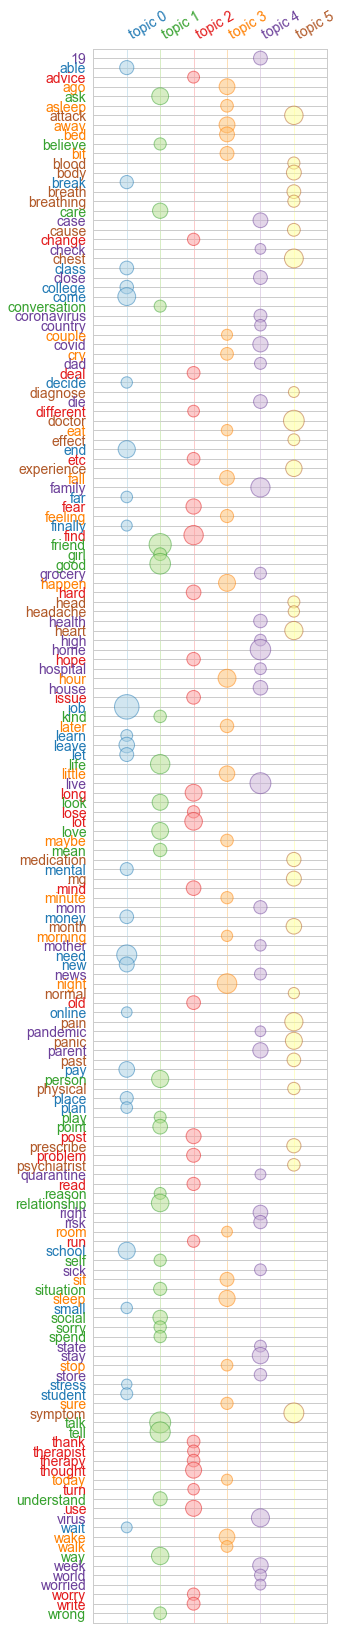

In [59]:
from textacy.viz.termite import draw_termite_plot

draw_termite_plot(np.array(termite_df.values),
                  termite_df.columns,
                  termite_df.index, 
                  highlight_cols=[0,1, 2, 3, 4, 5] )

## TSNE Visualization 

In [109]:
import random
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["t{}".format(i+1) for i in range(6)]
).astype(float)
topic_df.astype(int)
a1=[];
for i in range(topic_df.shape[0]):
    a2 = list(topic_df.iloc[i][topic_df.iloc[i]==1].index)
    random.shuffle(a2)
    a1.append(a2)
    
topic_df['label'] = a1


In [110]:
a2 = [topic_df.label[i] != [] for i in range(topic_df.shape[0])]
topic_df = topic_df[a2]

In [155]:
topic_df['new_label'] = [topic_df['label'].iloc[i][0] for i in range(topic_df.shape[0])]

In [156]:
new_corpus = df_doc_dep.iloc[topic_df.index]
new_corpus.label =  topic_df['new_label']

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [160]:
new_corpus1 = new_corpus.sample(n=1000)
new_corpus1

,Body,label
2848,know ppl use March fifth year clean thing lot ...,t3
15131,ex boyfriend pretend date 8 year fake marriage...,t6
6420,feel like sad excuse person hope young friend ...,t2
3298,hello people subreddit struggle year recently ...,t1
7670,hate talk mental health sound normal immediate...,t1
...,...,...
9815,hello guy post \n\n context 17 year old guy b...,t2
2037,hi work healthcare anxiety feel like feeling b...,t2
883,regular medication add mood stabilizer couple ...,t1
8868,feel like truly care anymore people rarely ask...,t4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

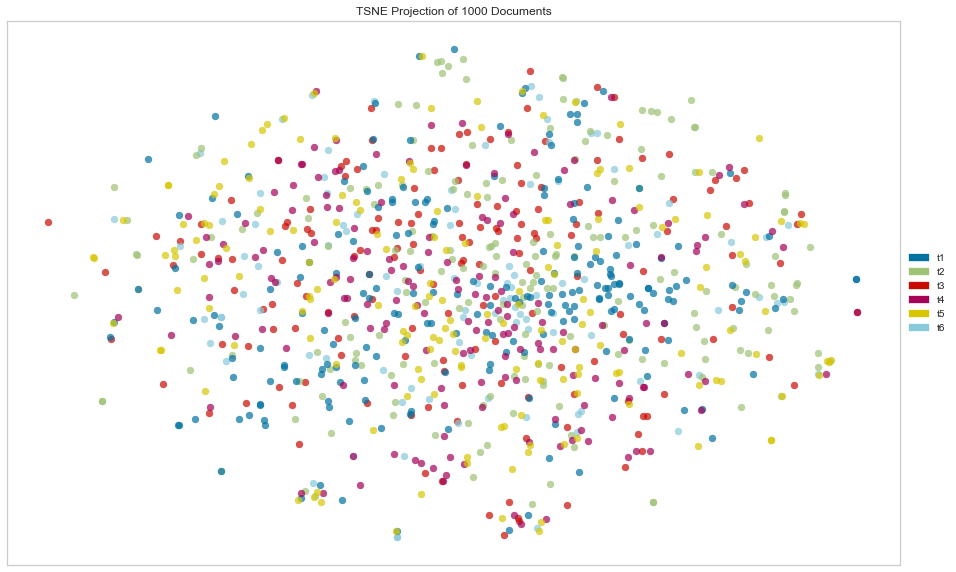

In [188]:
# from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = new_corpus1.Body

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = new_corpus1.label

# Create the visualizer and draw the vectors
fig, ax = plt.subplots(figsize=(20,10))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()


The topic words are those with the highest mutual information with the topic, rather than those with highest probability within the topic as in LDA. The mutual information with the topic is the number reported in each tuple. Theoretically, mutual information is always positive. If the CorEx output returns a negative mutual information from get_topics(), then the absolute value of that quantity is the mutual information between the topic and the absence of that word.

In [ ]:
#from corextopic import vis_topic as vt
#vt.vis_rep(model, column_label=words, prefix='topic-model-example')

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

## LDA Unsupervised

In [60]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=6, 
                                           random_state=2,
                                           update_every=1,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
#print the keyword in the 6 topics
pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.004*"ok" + 0.004*"scare" + 0.004*"hair" + 0.003*"age" + 0.003*"autism" + '
  '0.003*"reveal" + 0.003*"music" + 0.003*"swimming" + 0.003*"shelf" + '
  '0.002*"orgasm" + 0.002*"wire" + 0.002*"report" + 0.002*"Corona" + '
  '0.002*"wheel" + 0.002*"transplant" + 0.002*"cover" + 0.002*"alert" + '
  '0.002*"forum" + 0.002*"bike" + 0.002*"groggy" + 0.002*"heightened" + '
  '0.002*"mattress" + 0.002*"suspicious" + 0.002*"drinker" + 0.002*"lymph" + '
  '0.002*"asthma" + 0.002*"elephant" + 0.002*"hot" + 0.002*"phagocytosis" + '
  '0.002*"microglia" + 0.002*"   " + 0.002*"gang" + 0.002*"host" + '
  '0.002*"noise" + 0.002*"user" + 0.002*"node" + 0.002*"ride" + 0.001*"poem" + '
  '0.001*"shave" + 0.001*"follower" + 0.001*"coz" + 0.001*"specialty" + '
  '0.001*"States" + 0.001*"water" + 0.001*"alot" + 0.001*"w" + 0.001*"site" + '
  '0.001*"till" + 0.001*"click" + 0.001*"load" + 0.001*"poetry" + '
  '0.001*"website" + 0.001*"ed" + 0.001*"chirp" + 0.001*"lupus" + '
  '0.001*"stuff" + 0.001*"

In [63]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8573,"feel, \n\n , like, time, know, day, think, hel...","[thing, anxious, focus, mean, study, like, may..."
1,1,4.0,0.4023,"like, friend, \n\n , \n , want, know, people, ...","[know, midnight, know, homework, know, school,..."
2,2,1.0,0.7725,"feel, \n\n , like, time, know, day, think, hel...","[med, euphoric, feeling, consider, narcotic]"
3,3,1.0,0.6335,"feel, \n\n , like, time, know, day, think, hel...","[heart, feel, sense, yesterday, continually, w..."
4,4,1.0,0.7573,"feel, \n\n , like, time, know, day, think, hel...","[fear, swallow, small, bone, eat, chicken, sur..."
...,...,...,...,...,...
95,95,1.0,0.6786,"feel, \n\n , like, time, know, day, think, hel...","[learn, stomach, ache, minor, discomfort, scar..."
96,96,4.0,0.7149,"like, friend, \n\n , \n , want, know, people, ...","[sure, sub, post, stand, compliment, mad, litt..."
97,97,1.0,0.6965,"feel, \n\n , like, time, know, day, think, hel...","[hi, currently, work, kennel, hand, animal, at..."
98,98,1.0,0.9339,"feel, \n\n , like, time, know, day, think, hel...","[Ige, fear, kid, able, crawl, bed, parent, cry..."


In [64]:
df_dominant_topic.head(25)
#df_dominant_topic.to_csv(r'depression_2020_datest.csv')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8573,"feel, \n\n , like, time, know, day, think, hel...","[thing, anxious, focus, mean, study, like, may..."
1,1,4.0,0.4023,"like, friend, \n\n , \n , want, know, people, ...","[know, midnight, know, homework, know, school,..."
2,2,1.0,0.7725,"feel, \n\n , like, time, know, day, think, hel...","[med, euphoric, feeling, consider, narcotic]"
3,3,1.0,0.6335,"feel, \n\n , like, time, know, day, think, hel...","[heart, feel, sense, yesterday, continually, w..."
4,4,1.0,0.7573,"feel, \n\n , like, time, know, day, think, hel...","[fear, swallow, small, bone, eat, chicken, sur..."
5,5,1.0,0.6615,"feel, \n\n , like, time, know, day, think, hel...","[anxious, pretty, believe, panic, attack, hear..."
6,6,1.0,0.6972,"feel, \n\n , like, time, know, day, think, hel...","[listen, music, calm, nerve, anxious, night, n..."
7,7,1.0,0.9886,"feel, \n\n , like, time, know, day, think, hel...","[today, ROUGH, \n\n , start, 10/10, attack, dr..."
8,8,1.0,0.9203,"feel, \n\n , like, time, know, day, think, hel...","[sorry, long, caption, pretty, sum, November, ..."
9,9,1.0,0.9889,"feel, \n\n , like, time, know, day, think, hel...","[past, day, creep, anytime, feel, physical-, d..."


In [65]:
from collections import Counter
Counter(df_dominant_topic.Dominant_Topic)

Counter({1.0: 5508, 4.0: 979, 3.0: 108, 5.0: 541, 2.0: 11, 0.0: 7})

In [66]:
dictionary = words
corpus = corpus
lda = lda_model

In [70]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.220479  0.051479       1        1  63.856518
4      0.199225 -0.079911       2        1  17.169889
5      0.158240 -0.061333       3        1  13.071403
3     -0.108811  0.280759       4        1   4.829956
0     -0.230575 -0.092481       5        1   0.579362
2     -0.238559 -0.098514       6        1   0.492864, topic_info=     Category         Freq      Term        Total  loglift  logprob
85    Default  2201.000000            2201.000000  30.0000  30.0000
789   Default  2234.000000       \n   2234.000000  29.0000  29.0000
184   Default  2997.000000      work  2997.000000  28.0000  28.0000
16    Default  7460.000000      like  7460.000000  27.0000  27.0000
10    Default  1660.000000    friend  1660.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
1464   Topic6     4.296013  sleeping    17.711874   3.8961  -6.1679
840    Topic6     8.810607    online   366.439056   1.5848  -5.4497
4029   Topic6     3.842851   payment    13.263423   4.0739  -6.2794
1695   Topic6     4.350461      pill   146.565903   1.7955  -6.1553
3634   Topic6     3.323760   product    31.140673   3.0753  -6.4245

[422 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
10798      4  0.969720          \t 
11429      5  0.891486  \n\n\n\n\n 
0          1  0.747170        \n\n 
0          2  0.127965        \n\n 
0          3  0.102448        \n\n 
...      ...       ...          ...
235        4  0.001212         year
48         2  0.835273         yell
48         3  0.154999         yell
10029      6  0.907428            |
8810       2  0.967000        \n\n 

[724 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 4, 1, 3])